# 1. Initializations and Dataset Download

In [2]:
#normally downloaded data from kaggle
!pip install opendatasets --quiet #quiet:to make the installition in quite process
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ziadadelkhalifa
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 769MB/s]

# 2. Imports
Lets start by getting all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with mps.

In [3]:
import torch # Torch main framework
import torch.nn as nn # Used for getting the NN Layers
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creatning the objects
from torchsummary import summary # Visualize the model layers and number of parameters as summaary
from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy and it will be fine as it is a binary classfication problem if not we can ue percision and recall
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations

device = 'cuda' if torch.cuda.is_available() else 'cpu' # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

In [4]:
print(device)

cuda


# 3. Dataset
Now lets read the dataset, this lab was developed by Google Colab, so dataset downloaded and read from the path shown below. We will be reading the dataset using pandas `read_csv` function, then we will remove the nulls/missing data from our dataframe as a filteration process, keep in mind that this process is essential as missing data will stop the code from training. You can skip dropping the missing values if you are 100% sure that there are no missing values in your data. Also, we dropped the `id` column because it will not affect our classification at all. We printed the output possibilities as we can see its a binary classification. We printed also the data shape (rows, columns) After that we printed the dataset shape and we used the `head()` function to visualize the first 5 rows, this step is optional as it just allows us to see the first 5 rows and will not affect the training process.

In [5]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv") # Read the data

data_df.dropna(inplace = True) # Drop missing/null values

data_df.drop(["id"], axis =1, inplace = True) # Drop Id column, axis =1 means it a column
print("Output possibilities: ", data_df["Class"].unique()) # Possible Outputs
print("Data Shape (rows, cols): ", data_df.shape) # Print data shape
data_df.head() # Print/visualize the first 5 rows of the data

Output possibilities:  [1 0]
Data Shape (rows, cols):  (18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


# 4. Data Preprocessing
Now as you saw previously, data values are so big which may cause bad results. Its a crucial steps to normalize the dataset before we proceed. Lets normalize the dataset in the cell below.

In [6]:
original_df = data_df.copy() # Creating a copy of the original Dataframe to use to normalize inference

for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max() # Divide by the maximum of the column which will make max value of each column is 1
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


# 5. Data Splitting
We will detect the inputs and the outputs of the data which are X and Y respectively.

Then we will split our data into the following:

* Training Size 70%
* Validation Size 15%
* Testing Size 15%

We will do this by splitting our data twice using the train_test_split function in sklearn the function takes inputs, outputs and the testing size. After that we will print the training, validation and testing shapes and sizes. Then we will print the new shapes of our data.

In [7]:
X = np.array(data_df.iloc[:,:-1]) # Get the inputs, all rows and all columns except last column (output)
Y = np.array(data_df.iloc[:, -1]) # Get the ouputs, all rows and last column only (output column)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3) # Create the training split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) # Create the validation split

print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%") # Print training shape
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%") # Print validation shape
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%") # Print testing shape

Training set is:  12729  rows which is  70.0 %
Validation set is:  2728  rows which is  15.0 %
Testing set is:  2728  rows which is  15.0 %


# 6. Dataset Object
Now we will create the dataset object. This part is not complex but its a bit tricky. We need to convert our dataset to PyTorch Dataset object as it will be more efficient during training, you can use the dataset as its, but lets keep things professional and efficient. First we define our class that will be taking the main Dataset class with the concept of inheritance. Let's make the concept simpler. There is a big class that PyTorch, this class has several functions inside it, we will recreate that class and modify some functions to match our needs.

In the cell below, we rebuilt the constructor function which is `__init__`. We put X and Y as a parameters to this function which are the inputs and outputs respectively, then inside the function we define the inputs and converting it to tensors, then converting the outputs to tensors and we make the numbers as a `float32` Additionally, we moved all our data to cuda device. Then we modified the `__len__` and the `__getitem__` to match our needs which gets the specific length/shape of the data, and the data of specific row in our data respectively.

In [8]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device) #convert X whatever it is {array,pandas etc}to a tensor then pass it to the gpu
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):#get the lenght of X
        return len(self.X)
    def __getitem__(self, index):#return item
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

# 7. Training Hyper Parameters
Now we are setting the training hyperparameters, we defined some variables which are the batch size, number of training epochs, Hidden Neurons and learning rate.

In [9]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

# 8. Data Loaders
This concept may seem complicated, but its very easy, PyTorch provides a class called DataLoader which allows us to create objects of it to simplify the training.

Dataloader is an object that we can loop through it to train according to batches. When we start training, we loop through epochs, if you skip the batch size it means that the amount of training data in one batch is equal to the complete amount of training data, this method is not efficient and in most of the cases you need to train through using batches. Dataloader allows you to loop through the batches easily during the training. When you create a dataloader. You define the batch size and enable the shuffle to randomize the data and then you can loop through it in each epoch to train normally.

In the next cell, we defined a dataloader for each of our data (training,
validation and testing).
###Note

DataLoader = بيلف حوالين الـ Dataset عشان:

يقسمها لـ mini-batches.

يعمل shuffle لو محتاج.

يديك حلقة سهلة للتكرار على البيانات.

In [10]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [ ]:
for x,y in train_dataloader:
  print(x)
  print(y)
  break

# 9. Model Class
Creating a model in PyTorch seems not very straight forward in the beggining, but if you understand how machine learning and deep learning works, it will be easy for you to understand PyTorch structure easily.

In the next cell we define a new class MyModel that inherits from nn.Module like we did for the dataset. Remember, in simple terms, we want to redefine some functions in the class to match our needs. In the constructor which is `__init__` and we give it the bert model. Then super`(MyModel, self).__init__()` This line calls the constructor of the parent class nn.Module to ensure it's properly initialized. Which means we have the original constructor together with our part of it!

Then, we create our layers, a linear layer which represents the input and having the input size of 10 which is the number of columns of the input and the output of the number of hidden neurons, next layer is the output layer which have the input of hidden neurons and one output since we have a binary classification. Finally we have the activation function which is the sigmoid. Our model is pretty simple and straight forward, we are using a simple dataset and we just want to see how PyTorch can be used to build that.

In the function forward, this function is the forward propagation of the model, how is the data flowing inside the model from the input to the output. This means we can control this completely. That's how PyTorch is so customizable! In the below cell, we define the flow as follows, starting by input layer and followed by the output layer then the activation layer.

مثال من الكود بتاعك:
self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)


دي طبقة fully connected.

المدخلات = عدد الأعمدة في بياناتك (X.shape[1]).

المخرجات = HIDDEN_NEURONS (عدد النيورونات اللي انت اخترتها).

self.linear = nn.Linear(HIDDEN_NEURONS, 1)


الطبقة اللي بعدها.

المدخلات = عدد النيورونات اللي طالعة من الطبقة الأولى (HIDDEN_NEURONS).

المخرجات = 1 (لأنك بتعمل تصنيف ثنائي → احتمال واحد بين 0 و 1).

self.relu = nn.ReLU()
self.sigmoid = nn.Sigmoid()


هنا بتعرّف دوال التنشيط (activations) اللي هتستخدمها بين الطبقات.

مش بتغيّر عدد المدخلات أو المخرجات، لكن بتغيّر شكل القيم عشان تدخل طبقة تانية بشكل أفضل.

🔹 الخلاصة

__init__ = مكان تعريف "المكوّنات" أو "الطبقات" بتاعة الشبكة وتحديد input/output size لكل طبقة.

forward = بيحدد "إزاي البيانات هتمشي" بين المكوّنات دي خطوة بخطوة.

In [32]:
class MyModel(nn.Module):
    def __init__(self):

        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)#HIDDEN_NEURONS:output of this layer
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)

        x = self.linear(x)
        x = self.sigmoid(x)
        return x

# 10. Model Creation
Now lets create our model and move it to the assigned device (cuda if you have GPU or the CPU if you don't have any GPUs). Additionally, we will print the a `summary` of the model using the function summary which will take our model and the input size.

In [33]:
model = MyModel().to(device)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# 11. Loss and Optimizer
In the next cell, we will create the loss function which will be Binary Cross entropy and the optimizer `Adam` which will take the model parameters/weights and the learning rate.

In [34]:
criterion = nn.BCELoss()#Binary Cross Entropy
optimizer = Adam(model.parameters(), lr= LR)

# 12. Training
Now comes the exciting part. As we mentioned several times, nothing is complex here if you know how deep learning works. You just need to know PyTorch syntax. We start by initializing the for loop with the specified number of epochs. But before that we define 4 lists and inside the loop we define another 4 variables.

## Variables:
* `total_acc_train`: here we will keep tracking of the training accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch.

* `total_loss_train`: here we will keep tracking of the training loss progress during each epoch, we calculate the accuracy during the batch size and we use the loss value to optimize and modify the model parameters.

* `total_acc_val`: here we will keep tracking of the validation accuracy progress during each epoch, we calculate the accuracy during the batch size and we print it in the end for tracking the accuracy on each epoch and help us know if there is any overfitting.

* `total_loss_val`: here we will keep tracking of the validation loss progress during each epoch, we calculate the accuracy during the batch size.

## Lists:
* `total_acc_train_plot`: We append the losses of the training accuracy to visualize them at the end.

* `total_loss_train_plot`: We append the losses of the training to visualize them at the end.

* `total_acc_validation_plot`: We append the losses of the validation accuracy to visualize them at the end.

* `total_loss_validation_plot`: We append the losses of the validation to visualize them at the end.

## Training
Then, we start to loop through the training dataloaders, we use the enumerate functionality to loop through data and indices at the same time. We are not using the indices here, but lets kept it just if you want to try different stuff with the loop or debug. In the second loop, we start by getting our data from the data loader, then we move the inputs and labels to the cuda device. We allow the model to make a prediction or what is called forward propagation, then we get the output of the model and compare it with our original output using the loss criteration. We use the squeeze function to modify the shape of the output and make it returns a tensor with all specified dimensions of input of size 1 removed. we add the loss amount to `total_loss_train`. Additionally, we get the accuracy by comparing the correct batch with the predicted batch and we add it to the total_acc_train. Then we do the `batch_loss.backward()` which makes the backpropagation and we use the optimizer to do a step on the weights using `optimizer.step()` and then we reset the optimizer gradients using `optimizer.zero_grad()` which is a very important step that has to be done before proceeding.

## Validation
After that we exit the batch loop (train dataloader loop) and we start with the validation. Don't forget that we are still in the same epoch. In side that we start by with `torch.no_grad()` which means that we need the model to do predicitons without being trained. We just need to see the validation preformance. Then we do the same steps which are predicting and calculating loss and accuracy and storing these values.

At the end we print after each epoch the epoch number, training loss, training accuracy, validation loss and validation accuracy. We use the printing of "=" signs just for making the printing output looks clean.

'''
batch_loss.backward() → يحسب المشتقات (gradients).

optimizer.step() → يحدّث الأوزان.

optimizer.zero_grad() → يصفّر الجريدينتس عشان ما تتجمعش على اللي بعدها.

loop الأولى (epochs): كم مرة هتمر على كل البيانات.

loop الثانية (batches): بتقسم البيانات وتتعلم شوية بشوية في كل مرة.
'''

In [35]:
print(prediction.round())

tensor([1., 0., 1., 0., 0., 1., 1., 0.], device='cuda:0')


In [36]:
#to save the loss and accuracy after each epoc
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for data in train_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)#enter the input in the model we built and return the result in 1 dimention to be exactly as lables

        batch_loss = criterion(prediction, labels)#calculate the loss

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()#here will return the number of correct answers from number of rows in each batch like 5 from 8 so it will be 5

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():#torch.no_grad:means use the pytorch model jjusst for testing not training
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.2423 Train Accuracy: 77.6887 Validation Loss: 0.0406 Validation Accuracy: 96.9575
Epoch no. 2 Train Loss: 0.1285 Train Accuracy: 98.0046 Validation Loss: 0.0180 Validation Accuracy: 98.2771
Epoch no. 3 Train Loss: 0.0609 Train Accuracy: 98.4052 Validation Loss: 0.0101 Validation Accuracy: 98.5704
Epoch no. 4 Train Loss: 0.0381 Train Accuracy: 98.4759 Validation Loss: 0.0072 Validation Accuracy: 98.6070
Epoch no. 5 Train Loss: 0.0289 Train Accuracy: 98.5152 Validation Loss: 0.0058 Validation Accuracy: 98.6070
Epoch no. 6 Train Loss: 0.0242 Train Accuracy: 98.5938 Validation Loss: 0.0050 Validation Accuracy: 98.5337
Epoch no. 7 Train Loss: 0.0216 Train Accuracy: 98.6173 Validation Loss: 0.0046 Validation Accuracy: 98.6070
Epoch no. 8 Train Loss: 0.0199 Train Accuracy: 98.6645 Validation Loss: 0.0045 Validation Accuracy: 98.5704
Epoch no. 9 Train Loss: 0.0189 Train Accuracy: 98.6173 Validation Loss: 0.0041 Validation Accuracy: 98.6070
Epoch no. 10 Train Loss: 0.0

# 13. Testing
Now in this section, we will be testing our model, we will start the code by with `torch.no_grad():` which means that we are telling PyTorch that we don't want to train the model we will be using it only for testing. Then we will declare initial loss and accuracy as zeros, we will start by looping through the testing dataloader like we did before during training. Inside the loop, we got our data and we moved it to our GPU (cuda) and then we ran our model on the data and we got the predictions. After that we get the loss and then we add it to our overall loss, we do the same for accuracy, and finally we print the accuracy.

In [37]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.61%


# 14. Plotting and Visualizations (Optional)
The results may not be very good, feel free to play with the layers, hyperparameters and text filteration to achieve better performance!

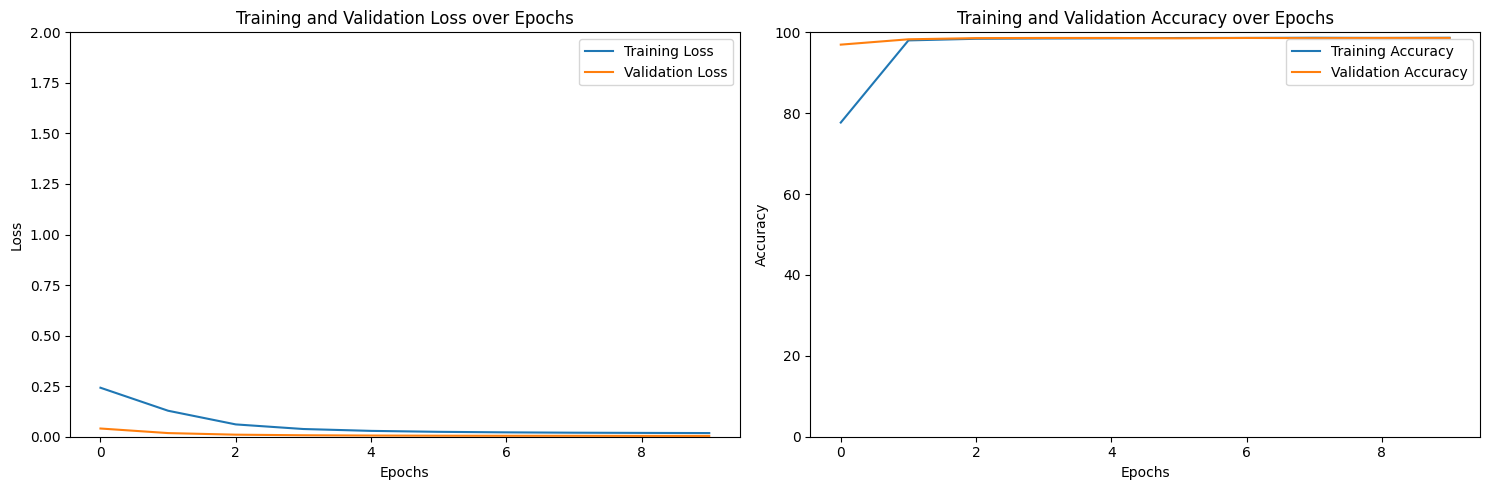

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

# 15. Inference
Now lets see how we can use the model in inference mode, inference means making predictions like you are in production.

In [39]:
original_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [40]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))

Area: 4537
Major Axis Length: 92.229316
Minor Axis Length: 64.012769
Eccentricity: 0.719916
Convex Area: 4677
EquivDiameter: 76.004525
Extent: 0.657536
Perimeter: 273.085
Roundness: 0.764510
AspectRation: 1.440796
tensor([0.0245], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  0
